In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: mps


### 1. Data preparation

Using the CIFAR-10 dataset:
- 60,000 32x32 color images
- 10 classes (6000 images each)
- 50000 training, 10000 testing

In [3]:
# VGG was trained on 224x224 imgs as per the paper
# we'll use 64x64 (resizing the 32x32 CIFAR10 imgs)

transform_train= transforms.Compose([
    transforms.Resize((64, 64)), # in order to save memory
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.RandomRotation(10),    # small random rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),   #small color adjustments
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) # got the mean and st. dev. values online

])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)), # in order to save memory
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) 
])

batch_size=128

# training data

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, 
                                        transform=transform_train)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)


# testing data
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, 
                                        transform=transform_test)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)        


# classes in CIFAR10:

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


sample images: 


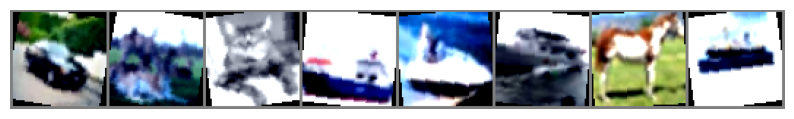

labels:  automobile deer cat ship ship ship horse ship


In [4]:
# display some images

def show_image(img):
    img = img / 2 + 0.5 # denormalize the image
    npimg = img.numpy()
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.show()

# getting some training imgs
data_iter = iter(train_loader)
images, labels = next(data_iter)

# printing
print("sample images: ")
show_image(torchvision.utils.make_grid(images[:8]))
print('labels: ', ' '.join(f"{classes[labels[j]]}" for j in range(8)))

In [5]:
# data info

print(f"training set size: {len(train_set)}")
print(f"test set size: {len(test_set)}")
print(f"image shape post transform: {images[0].shape}")

training set size: 50000
test set size: 10000
image shape post transform: torch.Size([3, 64, 64])


### 2. VGG-16 Architecture
- 3x3 filters
- 16 layers (19 for VGG-19)

![VGG-16 arch](architecture.png)

Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [6]:
import torch.nn as nn

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        # block 1: 2 x conv3-64 + MaxPool
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # block 2: 2 x conv3-128 + MaxPool
        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=2, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # block 3: 3 x Conv3-256 + MaxPool
        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #block 4: 3 x Conv3-512 + MaxPool
        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # block 5: 3 x Conv3-512 + MaxPool
        self.block_5= nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
